In [74]:
!pip freeze

absl-py==1.4.0
accelerate==1.12.0
access==1.1.10.post3
affine==2.4.0
aiofiles==24.1.0
aiohappyeyeballs==2.6.1
aiohttp==3.13.2
aiosignal==1.4.0
aiosqlite==0.22.0
alabaster==1.0.0
albucore==0.0.24
albumentations==2.0.8
ale-py==0.11.2
alembic==1.17.2
altair==5.5.0
annotated-doc==0.0.4
annotated-types==0.7.0
antlr4-python3-runtime==4.9.3
anyio==4.12.0
anywidget==0.9.21
argon2-cffi==25.1.0
argon2-cffi-bindings==25.1.0
array_record==0.8.3
arrow==1.4.0
arviz==0.22.0
astropy==7.2.0
astropy-iers-data==0.2025.12.15.0.40.51
astunparse==1.6.3
atpublic==5.1
attrs==25.4.0
audioread==3.1.0
Authlib==1.6.6
autograd==1.8.0
babel==2.17.0
backcall==0.2.0
beartype==0.22.9
beautifulsoup4==4.13.5
betterproto==2.0.0b6
bigframes==2.30.0
bigquery-magics==0.10.3
bleach==6.3.0
blinker==1.9.0
blis==1.3.3
blobfile==3.1.0
blosc2==3.12.2
bokeh==3.7.3
Bottleneck==1.4.2
bqplot==0.12.45
branca==0.8.2
brotli==1.2.0
CacheControl==0.14.4
cachetools==6.2.4
catalogue==2.0.10
certifi==2025.11.12
cffi==2.0.0
chardet==5.2.0
cha

# Load and extract data files

In [75]:
! unzip -o dataset.zip

unzip:  cannot find or open dataset.zip, dataset.zip.zip or dataset.zip.ZIP.


In [76]:
path = "./"

# Import modules and define functions for common use

In [77]:
!pip install japanize-matplotlib

In [78]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import japanize_matplotlib
from scipy.optimize import linear_sum_assignment
import matplotlib as mpl
import seaborn as sns
mpl.rcParams['svg.fonttype'] = 'none'

In [79]:
# Convert wide-format data (x1, y1, x2, y2, ...) to tidy data in the same format as manual
def convert_wide_to_long(df):
  col_list = df.columns
  value_vars = [col for col in col_list if col.startswith("x") or col.startswith("y")]
  id_vars = [col for col in col_list if not col.startswith("x") and not col.startswith("y")]
  df_melt = df.melt(value_vars=value_vars, id_vars=id_vars)
  df_melt["x_or_y"] = df_melt["variable"].str[0]
  df_melt["id"] = df_melt["variable"].str[1:]
  df_melt.drop("variable", axis=1, inplace=True)
  index_names = [item for item in list(df_melt.columns) if item not in ["value", "x_or_y"]]
  df_pivot = df_melt.pivot(index=index_names, columns="x_or_y", values="value")
  df_pivot.reset_index(inplace=True)
  return df_pivot

In [80]:
import copy
import cv2
import numpy as np

def load_frame_as_ndarray(video_path: str, frame_index: int) -> np.ndarray:
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        raise IOError(f"This video file cannot be loaded: {video_path}")

    # seek to the specified frame
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_index)

    ret, frame_bgr = cap.read()
    cap.release()

    if not ret:
        raise ValueError(f"Failed to load the frame {frame_index}")

    # BGR → RGB
    frame_rgb = cv2.cvtColor(frame_bgr, cv2.COLOR_BGR2RGB)

    return frame_rgb

# Load scale data

In [81]:
# Scale conversion table measuring the diameter of the dish in pixels in vertical and horizontal directions in the image.

df_scales = pd.read_excel(f"{path}/extracted trajectories/scales.xlsx", index_col=0)

In [82]:
df_scales["px_per_cm"] = ( df_scales["top_to_bottom(px)"] + df_scales["left_to_right(px)"] ) / 2 / df_scales["actual_size(cm)"]

# When setting the area threshold inside TRex, a value (9.0 cm) different from the actual dish size (8.3 cm) was used. Use this when converting Trex data.
df_scales["px_per_cm_trex_correct"] = ( df_scales["top_to_bottom(px)"] + df_scales["left_to_right(px)"] ) / 2 / df_scales["actual_size_used_in_trex"]
df_scales

,video_identity,condition,top_to_bottom(px),left_to_right(px),actual_size(cm),actual_size_used_in_trex,px_per_cm,px_per_cm_trex_correct
video_name,,,,,,,,
natural_H3,H3,natural,1052,1048,8.3,9,126.506024,116.666667
natural_H1,H1,natural,515,530,8.3,9,62.951807,58.055556
natural_H5,H5,natural,461,472,8.3,9,56.204819,51.833333
natural_Z2,Z2,natural,659,685,8.3,9,80.963855,74.666667
natural_Z3,Z3,natural,765,775,8.3,9,92.771084,85.555556
natural_Z5,Z5,natural,466,460,8.3,9,55.783133,51.444444
optimized_H1,H1,optimized,1126,1156,8.3,9,137.469880,126.777778
optimized_H3,H3,optimized,1080,1089,8.3,9,130.662651,120.500000
optimized_H5,H5,optimized,1156,1130,8.3,9,137.710843,127.000000


# Figure 3
Pick datasets and visualize

In [83]:
# Pick datasets to visualize
# condition name, video identity
data_sources = [["natural", "Z5"],
                ["natural", "Z3"],
                ["optimized", "Z3"],
                ["optimized", "Z5"],
               ]

In [84]:
dataframes = []
images = []
for condition_name, video_name in data_sources:
  video_path = f"{path}/videos_{condition_name}/{condition_name}_{video_name}.mp4"
  trex_data_path = f"{path}/extracted trajectories/{condition_name}/trex/{condition_name}_{video_name}_traj_all.csv"
  idt_data_path = f"{path}/extracted trajectories/{condition_name}/idtracker/{condition_name}_{video_name}_trajectories.csv"
  manu_data_path = f"{path}/extracted trajectories/{condition_name}/manual/{condition_name}_{video_name}.csv"
  uma_data_path = f"{path}/extracted trajectories/{condition_name}/uma_tracker/{condition_name}_{video_name}-position.csv"

  df_trex = pd.read_csv(trex_data_path)
  df_idt = pd.read_csv(idt_data_path)
  df_manu = pd.read_csv(manu_data_path)
  df_uma = pd.read_csv(uma_data_path)

  df_trex = convert_wide_to_long(df_trex)
  df_idt = convert_wide_to_long(df_idt)
  df_uma = convert_wide_to_long(df_uma)

  # Convert the unit of trajectry data of trex (cm --> px)
  df_trex.x = df_trex.x * df_scales.loc[f"{condition_name}_{video_name}", "px_per_cm_trex_correct"]
  df_trex.y = df_trex.y * df_scales.loc[f"{condition_name}_{video_name}", "px_per_cm_trex_correct"]


  dataframes.append(copy.deepcopy([df_manu, df_idt, df_uma, df_trex]))

  frame_index = 0
  frame_rgb = load_frame_as_ndarray(video_path, frame_index)
  images.append(frame_rgb)

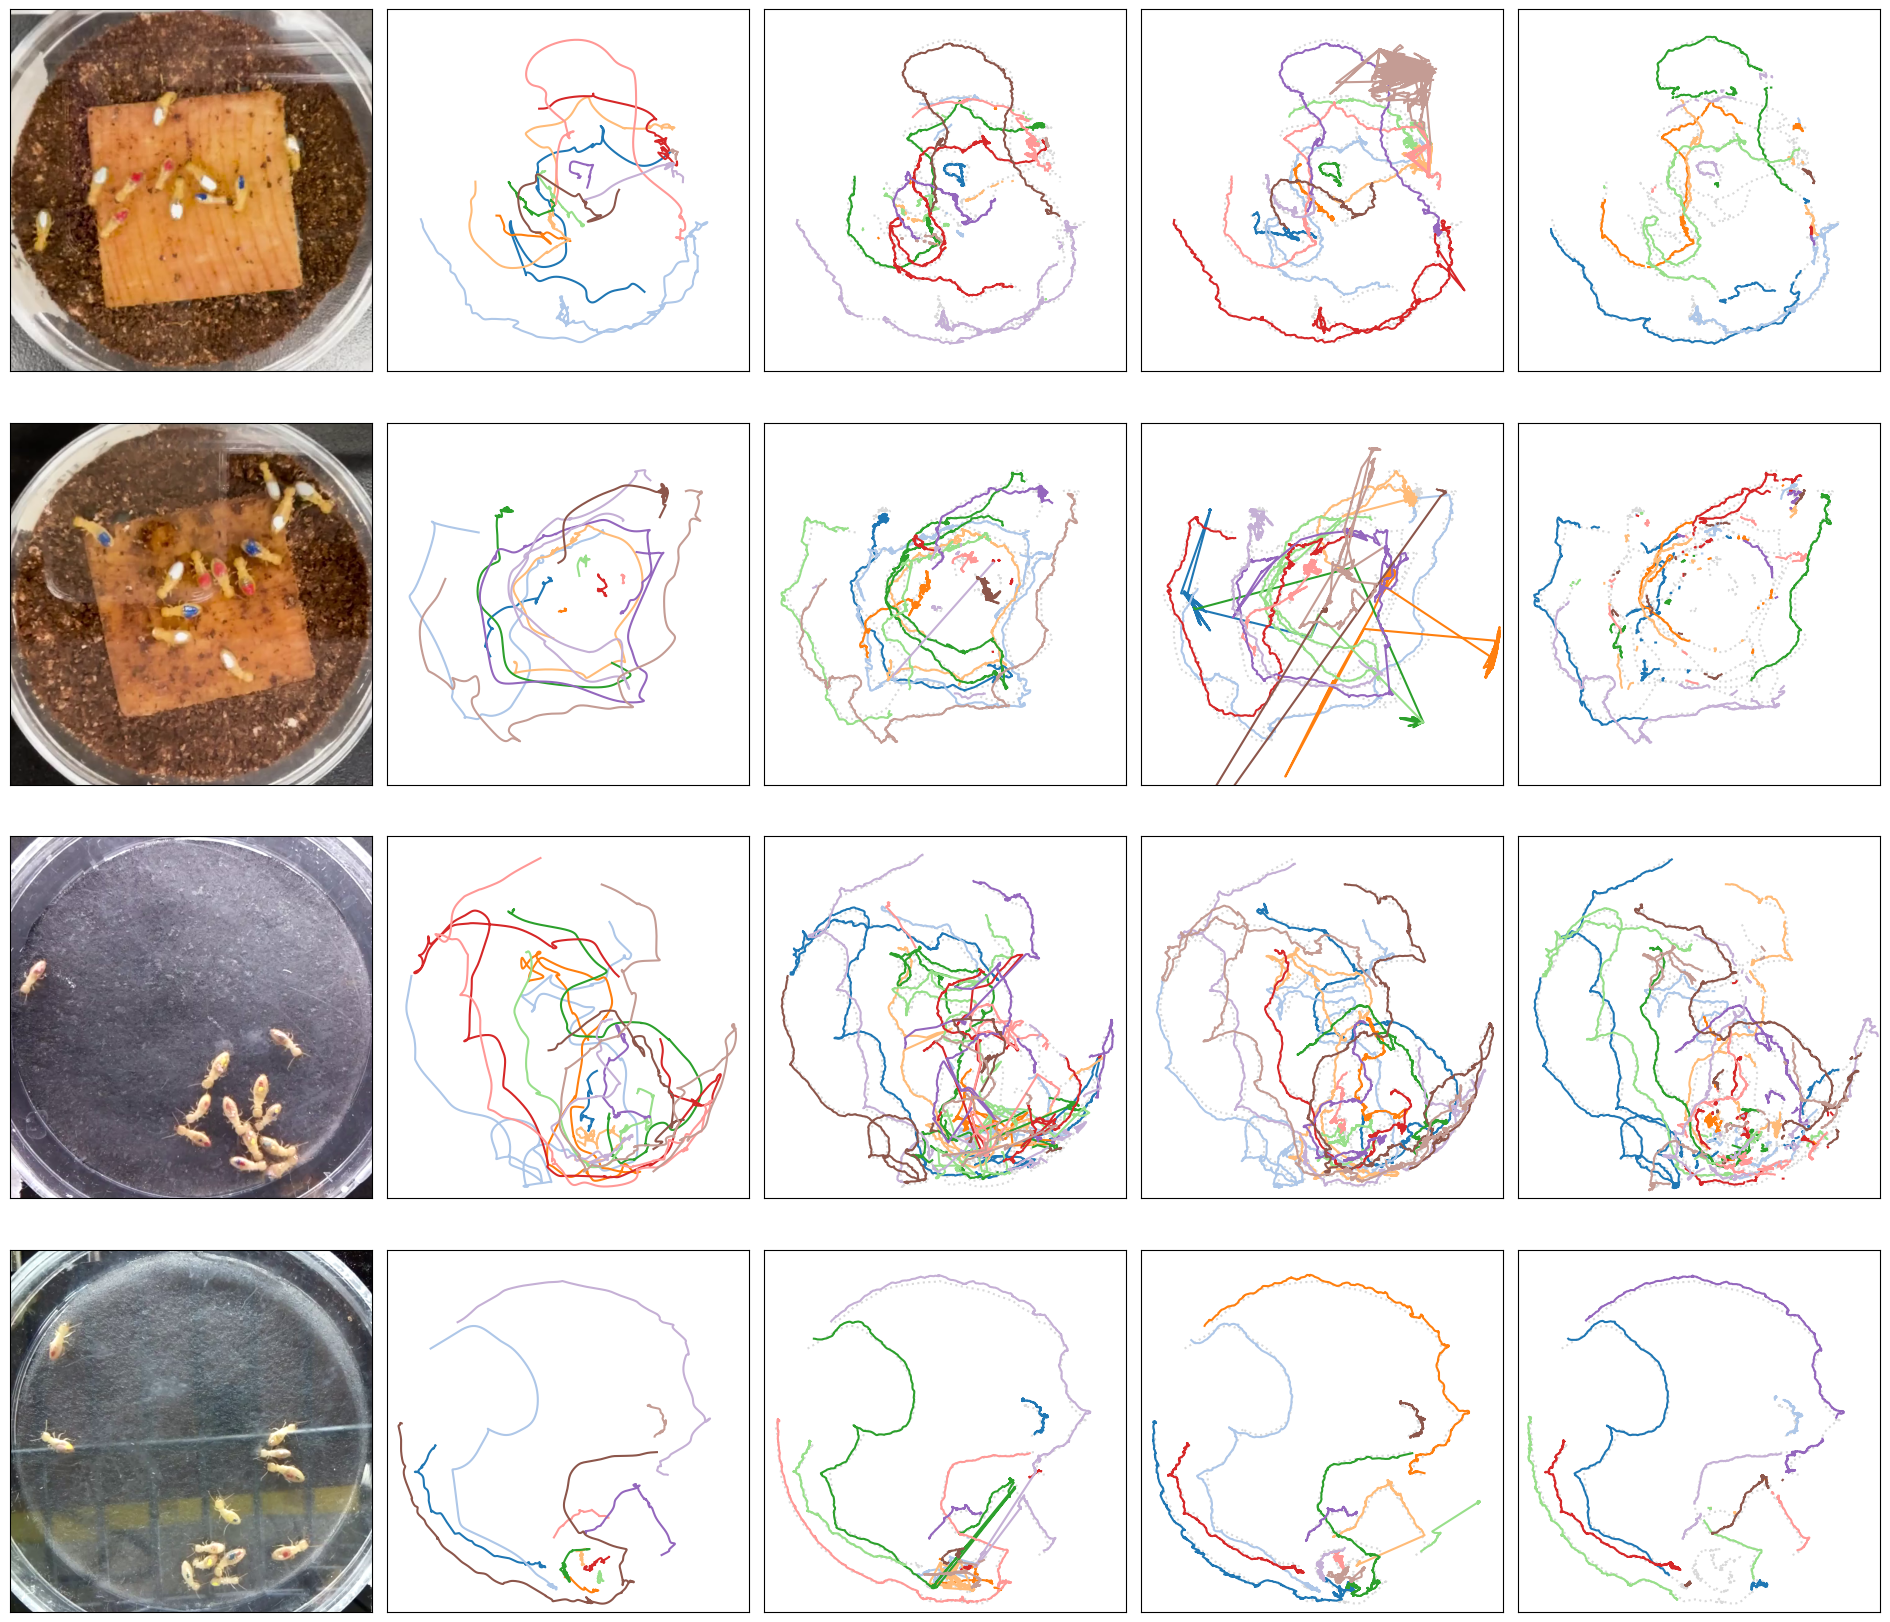

In [85]:
fig, axes = plt.subplots(len(dataframes), 5, sharex="row", sharey="row", figsize=(19, 17))
for x in range(len(dataframes)):
  for y in [1, 2, 3]:
    ax = axes[x][y + 1]
    df = dataframes[x][0]
    for id, df_ind in df.groupby("id"):
      ax.plot(df_ind.x, df_ind.y, ":", label=id, color="#d9d9d9", )

tab20 = plt.get_cmap("tab20").colors

# Plot trajectories
for x in range(len(dataframes)):
  for y in [0, 1, 2, 3]:
    ax = axes[x][y + 1]
    ax.set_prop_cycle(color=tab20)
    ax.set_aspect("equal")
    df = dataframes[x][y]
    for id, df_ind in df.groupby("id"):
      ax.plot(df_ind.x, df_ind.y, label=id)

# Draw images
for x in range(len(images)):
  image = images[x]
  y = 0
  ax = axes[x][y]
  ax.imshow(image)

# adjust plotting area
for x in range(len(dataframes)):
  for y in [0, 1, 2, 3, 4]:
    ax = axes[x][y]
    if x == 0:
      ax.set_ylim(445, 915)
      ax.set_xlim(95, 565)
    elif x == 1:
      ax.set_ylim(385, 1175)
      ax.set_xlim(70, 860)
    elif x == 2:
      ax.set_ylim(70, 1150)
      ax.set_xlim(245, 1325)
    elif x == 3:
      ax.set_ylim(20, 1190)
      ax.set_xlim(110, 1280)

    ax.tick_params(bottom=False, left=False, right=False, top=False)
    ax.tick_params(labelbottom=False, labelleft=False, labelright=False, labeltop=False)

fig.tight_layout()
fig.show()

In [86]:
fig.savefig("figure3_raw.svg")

# Figure 4(a)

In [87]:
# natural condition
path_h_natural = f"{path}/extracted trajectories/natural/manual/natural_H1.csv"
path_z_natural = f"{path}/extracted trajectories/natural/manual/natural_Z2.csv"

# optimized condition
path_h_optimized = f"{path}/extracted trajectories/optimized/manual/optimized_H5.csv"
path_z_optimized = f"{path}/extracted trajectories/optimized/manual/optimized_Z1.csv"

# convert px to cm; Here we use the exact size of petri dish
rate_h_natural = df_scales.loc[f"natural_H1", "px_per_cm"]
rate_z_natural = df_scales.loc[f"natural_Z2", "px_per_cm"]
rate_h_optimized = df_scales.loc[f"optimized_H5", "px_per_cm"]
rate_z_optimized = df_scales.loc[f"optimized_Z1", "px_per_cm"]

data_paths = [path_z_natural, path_h_natural, path_z_optimized, path_h_optimized]
data_rates = [rate_z_natural, rate_h_natural, rate_z_optimized, rate_h_optimized]

# Adjust the range to draw
offsets = [[0, -5],
           [1, -2.5],
           [-1, 0],
           [0, 0]]

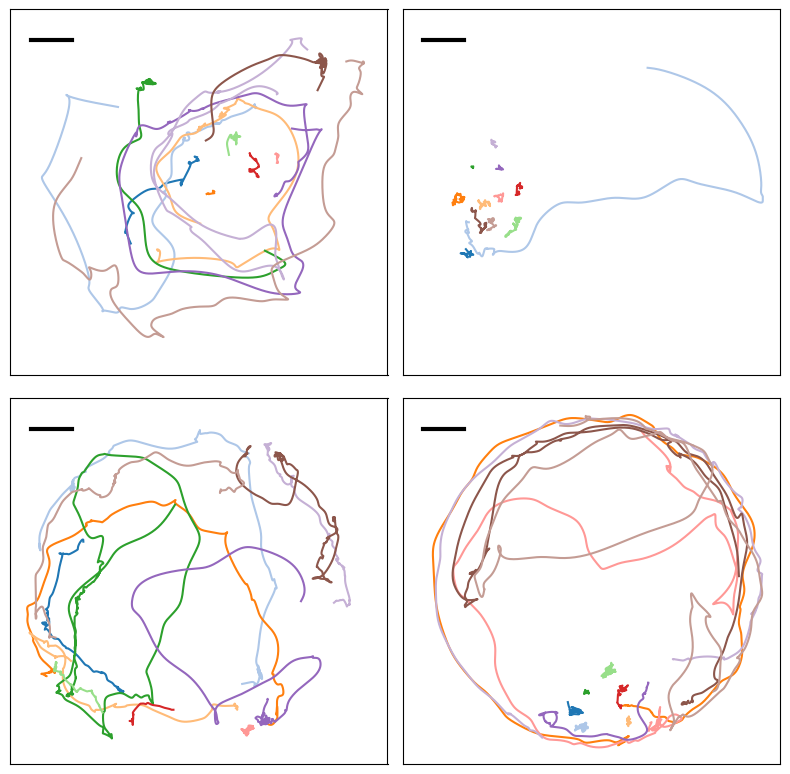

In [88]:
fig, axes = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(8, 8))

x = 0
y = 0

tab20 = plt.get_cmap("tab20").colors

for data_path, rate, offset in zip(data_paths, data_rates, offsets):
  df = pd.read_csv(data_path)
  ax = axes[y][x]
  ax.set_prop_cycle(color=tab20)
  for id, df_ind in df.groupby("id"):
    ax.plot(df_ind.x/rate + offset[0], df_ind.y/rate + offset[1], label=id)
  if x==1:
    x=0
    y=1
  else:
    x=1
  ax.set_aspect("equal")
  # no ticks and tick labels
  ax.tick_params(bottom=False, left=False, right=False, top=False)
  ax.tick_params(labelbottom=False, labelleft=False, labelright=False, labeltop=False)
  ax.plot([1.2, 2.2], [8.2, 8.2], color="black", linewidth=3)

fig.tight_layout()
fig.show()

In [89]:
fig.savefig("figure4(a)_raw.svg")

# Figure 4(b)
Comparison of trajectory length

In [90]:
result = []

for condition in ["natural", "optimized"]:
  filenames = sorted(os.listdir(f"{path}/extracted trajectories/{condition}/manual"), reverse=True)
  filenames = [filename for filename in filenames if filename.endswith(".csv")]
  for filename in filenames:
    df = pd.read_csv(f"{path}/extracted trajectories/{condition}/manual/{filename}")
    for id, df_individual in df.groupby("id"):
      df_individual["x_diff"] = df_individual["x"].diff()
      df_individual["y_diff"] = df_individual["y"].diff()
      df_individual["move_distance"] = (df_individual.x_diff ** 2 + df_individual.y_diff ** 2) ** (1/2)
      total_move = df_individual.move_distance.sum()
      condition, species_rep = filename.split("_")
      species, rep = species_rep[0], species_rep[1]
      result.append([condition, filename.replace(".csv", ""), rep, species, id,  total_move])

results_df = pd.DataFrame(result, columns=["condition", "source_file", "rep", "species", "id", "total_move_px"])

# convert units from px to cm
results_df = results_df.join(df_scales['px_per_cm'], on='source_file', how='left')
results_df["total_move_cm"] = results_df["total_move_px"] / results_df["px_per_cm"]

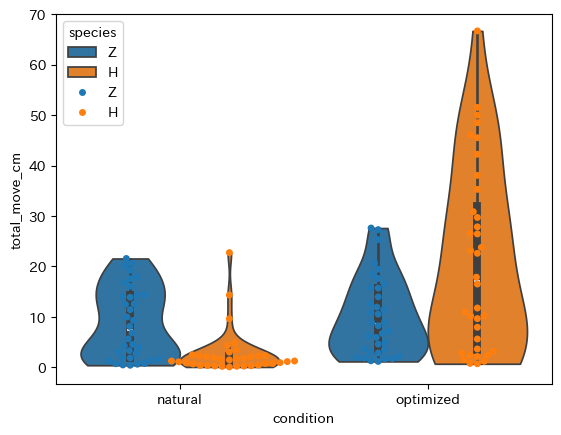

In [91]:
y = "total_move_cm"
fig, ax=plt.subplots()
sns.violinplot(results_df, x="condition", y=y, hue="species", density_norm="width", cut=0, ax=ax)
sns.swarmplot(results_df, x="condition", y=y, hue="species", dodge=True, ax=ax)
fig.show()

In [92]:
fig.savefig("figure4(b)_raw.svg")

# Statistical analysis of walking distance

In [93]:
import statsmodels.api as sm
from statsmodels.formula.api import mixedlm
from scipy.stats import chi2

In [94]:
df_lmm = results_df.copy()

In [95]:
lmm_formula_full = 'total_move_cm ~ C(condition) + C(species) + C(condition):C(species)'
lmm_model = mixedlm(lmm_formula_full, data=df_lmm, groups=df_lmm['source_file']).fit()

lmm_formula_reduced_interaction = 'total_move_cm ~ C(condition) + C(species)'
lmm_model_reduced_interaction = mixedlm(lmm_formula_reduced_interaction, data=df_lmm, groups=df_lmm['source_file']).fit()

lmm_formula_reduced_condition = 'total_move_cm ~ C(species)'
lmm_model_reduced_condition = mixedlm(lmm_formula_reduced_condition, data=df_lmm, groups=df_lmm['source_file']).fit()

In [96]:
# Effect of Interaction
llf_full = lmm_model.llf
llf_reduced = lmm_model_reduced_interaction.llf

lr_statistic = -2 * (llf_reduced - llf_full)
df_diff = 1
p_value_interaction = chi2.sf(lr_statistic, df_diff)

print(f"p = {p_value_interaction}")
print(f"df = {df_diff}")
print(f"chisq = {lr_statistic:.4f}")

p = 0.002049014083320671
df = 1
chisq = 9.5051


In [97]:
# Effect of condition
llf_condition = lmm_model_reduced_interaction.llf
llf_reduced = lmm_model_reduced_condition.llf

lr_statistic = -2 * (llf_reduced - llf_condition)
df_diff = 1
p_value_interaction = chi2.sf(lr_statistic, df_diff)

print(f"p = {p_value_interaction}")
print(f"df = {df_diff}")
print(f"chisq = {lr_statistic:.4f}")

p = 0.003590791982090248
df = 1
chisq = 8.4800
